In [23]:
from pinecone import Pinecone
from pinecone import ServerlessSpec
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt


In [24]:
def category_scores(text):
    pc = Pinecone(api_key="pcsk_2wP34Q_BMcTpsBMdLgVjxq5SrFidKYDnr9Xj2heFtv6iEKdVUnVsyv58XLXFpBT8rk2r2U")
    index_name = "document--embeddings"

    # Delete and recreate index
    pc.delete_index(index_name)
    pc.create_index(
        name=index_name,
        dimension=1024,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

    # Wait until index is ready
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

    index = pc.Index(index_name)

    # Insert input text into Pinecone
    data = [{"id": "vec1", "text": text}]
    embeddings = pc.inference.embed(
        model="multilingual-e5-large",
        inputs=[text],
        parameters={"input_type": "passage", "truncate": "END"}
    )
    vectors = [{
        "id": "vec1",
        "values": embeddings[0].values,
        "metadata": {"text": text}
    }]
    index.upsert(vectors=vectors, namespace="ns1")

    # Define categories
    categories = [
        "atheism", "space", "pc hardware", "windows computer",
        "for sale", "automobiles", "motorcycles", "baseball", "hockey",
        "crypto", "electronics", "medicine", "Christianity", "guns",
        "middle east", "misc politics", "misc religion", "mac hardware",
        "graphics", "windows misc"
    ]

    # Run similarity search with retry logic
    scores = {}
    for category in categories:
        query = f"Text that discusses {category}"
        embedding = pc.inference.embed(
            model="multilingual-e5-large",
            inputs=[query],
            parameters={"input_type": "query"}
        )

        max_retries = 5
        retry_delay = 2
        attempt = 0
        score = 0.0

        while attempt < max_retries:
            result = index.query(
                namespace="ns1",
                vector=embedding[0].values,
                top_k=3,
                include_values=False,
                include_metadata=True
            )
            if result['matches']:
                score = result['matches'][0]['score']
                break
            else:
                attempt += 1
                print(f"No match for '{category}' (attempt {attempt}/{max_retries}), retrying...")
                time.sleep(retry_delay)

        scores[category] = score
        print(f"{category}: {score:.4f}")
        time.sleep(10)

    # Convert to DataFrame
    df_scores = pd.DataFrame([scores])

    # Sort the DataFrame by score (descending)
    df_sorted = df_scores.iloc[:, :].sort_values(by=0, axis=1, ascending=False)

    # Create bar plot
    plt.figure(figsize=(16, 6))
    plt.bar(df_sorted.columns, df_sorted.iloc[0, :])
    plt.ylim(0.7, 0.9)
    plt.xlabel("Categories")
    plt.ylabel("Scores")
    plt.title("Sorted Scores")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


No match for 'atheism' (attempt 1/5), retrying...
No match for 'atheism' (attempt 2/5), retrying...
No match for 'atheism' (attempt 3/5), retrying...
No match for 'atheism' (attempt 4/5), retrying...
atheism: 0.7519
space: 0.8259
pc hardware: 0.7453
windows computer: 0.7458
for sale: 0.7140
automobiles: 0.7473
motorcycles: 0.7164
baseball: 0.7323
hockey: 0.7174
crypto: 0.7304
electronics: 0.7491
medicine: 0.7490
Christianity: 0.7359
guns: 0.7297
middle east: 0.7386
misc politics: 0.7274
misc religion: 0.7295
mac hardware: 0.7279
graphics: 0.7443
windows misc: 0.7376


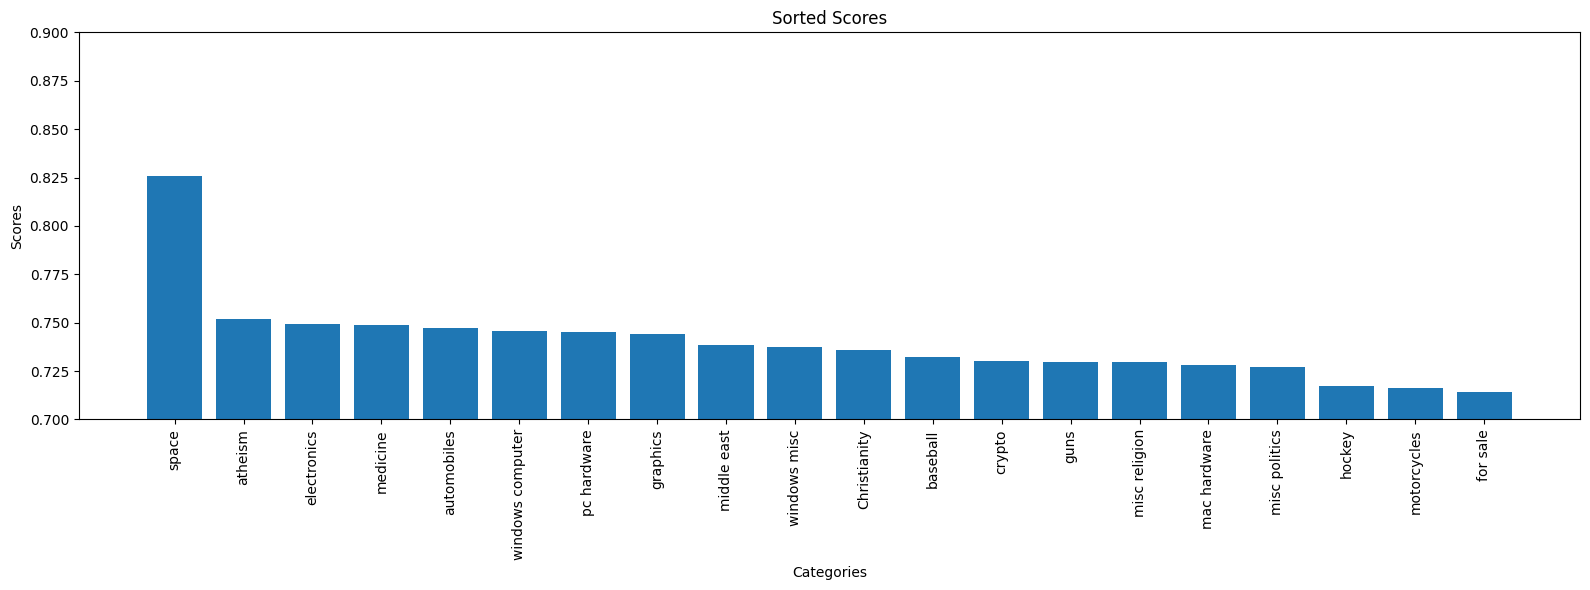

None


In [25]:
text = "Space is a vast, mysterious expanse that extends far beyond our planet, filled with stars, galaxies, and cosmic phenomena. It’s a near-perfect vacuum, where temperatures can plunge and gravity is almost nonexistent. Scientists explore space to understand the origins of the universe, the possibility of life beyond Earth, and the nature of black holes and dark matter. Despite its silence, space continues to spark imagination, curiosity, and discovery across generations."
df = category_scores(text)
print(df)